## Recap: Domain Decomposition convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

### Hands-on with PETSc: demonstrate these estimates

* Linear Poisson with geometric multigrid: `src/ksp/ksp/examples/tutorials/ex29.c`
* Nonlinear problems
  * Symmetric scalar problem: `src/snes/examples/tutorials/ex5.c`
  * Nonsymmetric system (lid/thermal-driven cavity): `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`

#### Example: Inhomogeneous Poisson

$$ -\nabla\cdot \Big( \rho(x,y) \nabla u(x,y) \Big) = e^{-10 (x^2 + y^2)} $$

in $\Omega = [0,1]^2$ with variable conductivity

$$\rho(x,y) = \begin{cases}
    \rho_0 & (x,y) \in [1/3, 2/3]^2 \\
    1 & \text{otherwise}
    \end{cases} $$
    
where $\rho_0 > 0$ is a parameter (with default $\rho_0 = 1$).

In [18]:
%%bash

# You may need to change these for your machine
PETSC_DIR=$HOME/petsc PETSC_ARCH=ompi-optg

# Build the example
make -C $PETSC_DIR -f gmakefile $PETSC_ARCH/tests/ksp/ksp/examples/tutorials/ex29

# Link it from the current directory to make it easy to run below
cp -sf $PETSC_DIR/$PETSC_ARCH/tests/ksp/ksp/examples/tutorials/ex29 .

make: Entering directory '/home/jed/petsc'
make: 'ompi-optg/tests/ksp/ksp/examples/tutorials/ex29' is up to date.
make: Leaving directory '/home/jed/petsc'


In [129]:
# Prints solution DM and then a coordinate DM
! mpiexec -n 2 ./ex29 -da_refine 2 -dm_view

DM Object: 2 MPI processes
  type: da
Processor [0] M 9 N 9 m 1 n 2 w 1 s 1
X range of indices: 0 9, Y range of indices: 0 5
Processor [1] M 9 N 9 m 1 n 2 w 1 s 1
X range of indices: 0 9, Y range of indices: 5 9
DM Object: 2 MPI processes
  type: da
Processor [0] M 9 N 9 m 1 n 2 w 2 s 1
X range of indices: 0 9, Y range of indices: 0 5
Processor [1] M 9 N 9 m 1 n 2 w 2 s 1
X range of indices: 0 9, Y range of indices: 5 9


In [134]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_view_solution draw -draw_pause 5 -draw_cmap plasma

This problem is nonsymmetric due to boundary conditions, though symmetric solvers like CG and MINRES may still converge

In [141]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_monitor_true_residual -ksp_view -ksp_type gmres

  0 KSP preconditioned resid norm 1.338744788815e-02 true resid norm 1.433852280437e-02 ||r(i)||/||b|| 1.000000000000e+00
  1 KSP preconditioned resid norm 6.105013156491e-03 true resid norm 8.819020609674e-03 ||r(i)||/||b|| 6.150578222039e-01
  2 KSP preconditioned resid norm 3.380566739974e-03 true resid norm 3.966597605983e-03 ||r(i)||/||b|| 2.766392089410e-01
  3 KSP preconditioned resid norm 2.248884854426e-03 true resid norm 1.950654466953e-03 ||r(i)||/||b|| 1.360429169426e-01
  4 KSP preconditioned resid norm 1.603958727893e-03 true resid norm 1.729343487982e-03 ||r(i)||/||b|| 1.206082043163e-01
  5 KSP preconditioned resid norm 1.017005335066e-03 true resid norm 1.108652090238e-03 ||r(i)||/||b|| 7.731982613301e-02
  6 KSP preconditioned resid norm 5.817999897588e-04 true resid norm 7.954596575686e-04 ||r(i)||/||b|| 5.547709958842e-02
  7 KSP preconditioned resid norm 3.102671011646e-04 true resid norm 4.651546500795e-04 ||r(i)||/||b|| 3.244090457755e-02
  8 KSP preconditioned r

### Default parallel solver

* Krylov method: GMRES
  * restart length of 30 to bound memory requirement and orthogonalization cost
  * classical Gram-Schmidt (compare `-ksp_gmres_modifiedgramschmidt`)
  * left preconditioning, uses preconditioned norm
  $$ P^{-1} A x = P^{-1} b $$
  * `-ksp_norm_type unpreconditioned`
  $$ A P^{-1} (P x) = b $$
  * Can estimate condition number using Hessenberg matrix
    * `-ksp_monitor_singular_value`
    * `-ksp_view_singularvalues`
    * Contaminated by restarts, so turn off restart `-ksp_gmres_restart 1000` for accurate results
* Preconditioner: block Jacobi
  * Expect condition number to scale with $1/(H h)$ where $H$ is the subdomain diameter and $h$ is the element size
  * One block per MPI process
    * No extra memory to create subdomain problems
    * Create two blocks per process: `-pc_bjacobi_local_blocks 2`
  * Each subdomain solver can be configured/monitored using the `-sub_` prefix
    * `-sub_ksp_type preonly` (default) means just apply the preconditioner
  * Incomplete LU factorization with zero fill
    * $O(n)$ cost to compute and apply; same memory as matrix $A$
    * gets weaker as $n$ increases
    * can fail unpredictably at the worst possible time
    * Allow "levels" of fill: `-sub_pc_factor_levels 2`
  * Try `-sub_pc_type lu`

In [147]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_monitor -ksp_view -sub_pc_factor_levels 3

  0 KSP Residual norm 3.321621226957e-02 
  1 KSP Residual norm 6.488371997792e-03 
  2 KSP Residual norm 3.872608843511e-03 
  3 KSP Residual norm 2.258796172567e-03 
  4 KSP Residual norm 6.146527388370e-04 
  5 KSP Residual norm 4.540373464970e-04 
  6 KSP Residual norm 1.994013489521e-04 
  7 KSP Residual norm 2.170446909144e-05 
  8 KSP Residual norm 7.079429242940e-06 
  9 KSP Residual norm 2.372198219605e-06 
 10 KSP Residual norm 9.203675161062e-07 
 11 KSP Residual norm 2.924907588760e-07 
KSP Object: 2 MPI processes
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: 2 MPI processes
  type: bjacobi
    number of blocks = 2
    Local solve is same for all blocks, in the follow

### Scaling estimates

#### Dependence on $h$

In [54]:
! mpiexec -n 16 --oversubscribe ./ex29 -da_refine 3 -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues

Linear solve converged due to CONVERGED_RTOL iterations 20
Iteratively computed extreme singular values: max 1.9384 min 0.0694711 max/min 27.9023


In [60]:
%%bash

for refine in {4..8}; do
  mpiexec -n 16 --oversubscribe ./ex29 -da_refine $refine -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues
done

Linear solve converged due to CONVERGED_RTOL iterations 27
Iteratively computed extreme singular values: max 1.98356 min 0.0338842 max/min 58.5395
Linear solve converged due to CONVERGED_RTOL iterations 36
Iteratively computed extreme singular values: max 2.04703 min 0.0167502 max/min 122.209
Linear solve converged due to CONVERGED_RTOL iterations 47
Iteratively computed extreme singular values: max 2.12834 min 0.00830794 max/min 256.182
Linear solve converged due to CONVERGED_RTOL iterations 62
Iteratively computed extreme singular values: max 2.1865 min 0.00412757 max/min 529.731
Linear solve converged due to CONVERGED_RTOL iterations 82
Iteratively computed extreme singular values: max 2.22724 min 0.00206119 max/min 1080.56


In [95]:
%%bash

for refine in {3..8}; do
  mpiexec -n 16 --oversubscribe ./ex29 -da_refine $refine -pc_type asm -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues
done

Linear solve converged due to CONVERGED_RTOL iterations 12
Iteratively computed extreme singular values: max 1.39648 min 0.183011 max/min 7.63057
Linear solve converged due to CONVERGED_RTOL iterations 16
Iteratively computed extreme singular values: max 1.68852 min 0.0984075 max/min 17.1584
Linear solve converged due to CONVERGED_RTOL iterations 23
Iteratively computed extreme singular values: max 1.8569 min 0.0494302 max/min 37.5661
Linear solve converged due to CONVERGED_RTOL iterations 31
Iteratively computed extreme singular values: max 1.9503 min 0.0247646 max/min 78.7537
Linear solve converged due to CONVERGED_RTOL iterations 41
Iteratively computed extreme singular values: max 2.03979 min 0.0123563 max/min 165.081
Linear solve converged due to CONVERGED_RTOL iterations 54
Iteratively computed extreme singular values: max 2.12275 min 0.00615712 max/min 344.764


In [96]:
%%bash
cat > results.csv <<EOF
method,refine,its,cond
bjacobi,3,20,27.90
bjacobi,4,27,58.54
bjacobi,5,36,122.2
bjacobi,6,47,256.2
bjacobi,7,62,529.7
bjacobi,8,82,1080.6
asm,3,12,7.63
asm,4,16,17.15
asm,5,23,37.57
asm,6,31,78.75
asm,7,41,165.1
asm,8,54,344.8
EOF

In [1]:
%matplotlib inline
import pandas
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df = pandas.read_csv('results.csv')
n1 = 2**(df.refine + 1) # number of points per dimension
df['P'] = 16      # number of processes
df['N'] = n1**2    # number of dofs in global problem
df['h'] = 1/n1
df['H'] = 0.25 # 16 procs = 4x4 process grid
df['1/Hh'] = 1/(df.H * df.h)

,method,refine,its,cond,P,N,h,H,1/Hh
0,bjacobi,3,20,27.90,16,256,0.062500,0.25,64.0
1,bjacobi,4,27,58.54,16,1024,0.031250,0.25,128.0
2,bjacobi,5,36,122.20,16,4096,0.015625,0.25,256.0
3,bjacobi,6,47,256.20,16,16384,0.007812,0.25,512.0
4,bjacobi,7,62,529.70,16,65536,0.003906,0.25,1024.0
5,bjacobi,8,82,1080.60,16,262144,0.001953,0.25,2048.0
6,asm,3,12,7.63,16,256,0.062500,0.25,64.0
7,asm,4,16,17.15,16,1024,0.031250,0.25,128.0
8,asm,5,23,37.57,16,4096,0.015625,0.25,256.0
9,asm,6,31,78.75,16,16384,0.007812,0.25,512.0


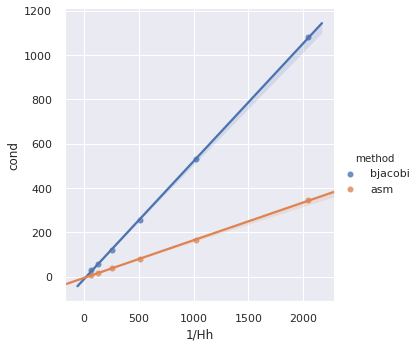

In [3]:
seaborn.lmplot(x='1/Hh', y='cond', hue='method', data=df)
df

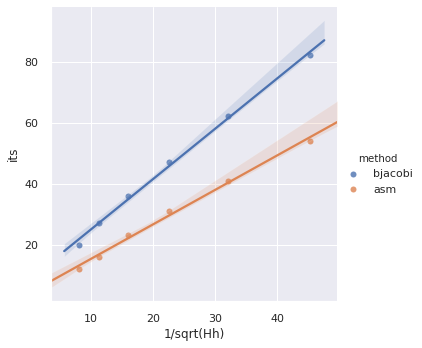

In [4]:
import numpy as np
df['1/sqrt(Hh)'] = np.sqrt(df['1/Hh'])
plt.rc('figure', figsize=(16, 9))
g = seaborn.lmplot(x='1/sqrt(Hh)', y='its', hue='method', data=df);

In [5]:
from scipy.stats import linregress

bjacobi = df[df.method == 'bjacobi']
asm = df[df.method == 'asm']
bjacobi_its = linregress(bjacobi['1/sqrt(Hh)'], bjacobi['its'])
asm_its = linregress(asm['1/sqrt(Hh)'], asm['its'])
bjacobi_its, asm_its

(LinregressResult(slope=1.649535193425483, intercept=8.498251134591065, rvalue=0.998633733566655, pvalue=2.7987507565052237e-06, stderr=0.043157836341681514),
 LinregressResult(slope=1.130138246216531, intercept=4.034979240523391, rvalue=0.9973956316037952, pvalue=1.0165269744723222e-05, stderr=0.04086178847687418))

#### Cost
Let $n = N/P$ be the subdomain size and suppose $k$ iterations are needed.

* Matrix assembly scales like $O(n)$ (perfect parallelism)
* 2D factorization in each subdomain scales as $O(n^{3/2})$
* Preconditioner application scales like $O(n \log n)$
* Matrix multiplication scales like $O(n)$
* GMRES scales like $O(k^2 n) + O(k^2 \log P)$
  * With restart length $r \ll k$, GMRES scales with $O(krn) + O(kr\log P)$

In [126]:
! mpiexec -n 2 --oversubscribe ./ex29 -da_refine 8 -pc_type asm -sub_pc_type lu -ksp_converged_reason -log_view

Linear solve converged due to CONVERGED_RTOL iterations 25
************************************************************************************************************************
***             WIDEN YOUR WINDOW TO 120 CHARACTERS.  Use 'enscript -r -fCourier9' to print this document            ***
************************************************************************************************************************

---------------------------------------------- PETSc Performance Summary: ----------------------------------------------

./ex29 on a ompi-optg named joule.int.colorado.edu with 2 processors, by jed Wed Oct 16 10:57:30 2019
Using Petsc Development GIT revision: v3.12-32-g78b8d9f084  GIT Date: 2019-10-03 10:45:44 -0500

                         Max       Max/Min     Avg       Total 
Time (sec):           1.484e+00     1.000   1.484e+00
Objects:              1.040e+02     1.000   1.040e+02
Flop:                 1.432e+09     1.004   1.429e+09  2.857e+09
Flop/sec:          

## Suggested exercises

* There is no substitute for experimentation.  Try some different methods or a different example.  How do the constants and scaling compare?
* Can you estimate parameters to model the leading costs for this solver?
  * In your model, how does degrees of freedom solved per second per process depend on discretization size $h$?
  * What would be optimal?
  
## An approach to modeling

We have conducted:
* a few experiments to validate the mathematical estimates for condition number and number of iterations
  * even when the theorem exists, we need to confirm that we're in the asymptotic regime
  * execution time does not matter at all for this; it's checking the math/convergence rates
  * indeed, we ran oversubscribed (more processes than cores)
* one performance experiment on representative hardware (`-log_view`)
  * this was on my laptop, but could have been on a couple nodes of a cluster

The performance experiment(s) enables us to fill in constants to estimate time.
These models could be more sophisticated, accounting for cache sizes, message sizes, and the like.
We implement this performance model in code, dropping in the timing constants from the experiment above, then run synthetic experiments to map out estimated performance in various scaling modes.

In [6]:
def perf_model(h, P, method, regress_its):
    n1 = 1/h
    N = n1**2
    n = N / P
    H = 1/np.sqrt(P)
    its = regress_its.intercept + regress_its.slope / np.sqrt(H*h)
    nref = (2**9 + 1)**2/2 # 8 levels of refinement from a 3x3 (2x2 element) grid
    pc_setup = 8.5827e-01 / nref**1.5 * n**1.5
    pc_apply = 3.3956e-01 / 26 / (nref * np.log(nref)) * (n * np.log(n))
    matmult =  2.8539e-02 / 25 / nref * n
    gmres = 8.4230e-02 / 25 / nref * n + 30e-6
    total = pc_setup + its*(pc_apply + matmult + gmres)
    return dict(h=h, H=H, n=n, N=N, P=P, method=method, its=its,
                pc_setup=pc_setup, pc_apply=its*pc_apply, matmult=its*matmult,
                gmres=its*gmres)

mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
mdf.append(perf_model(.5**9, 2, 'asm', asm_its), ignore_index=True)

,h,H,n,N,P,method,its,pc_setup,pc_apply,matmult,gmres
0,0.001953,0.707107,131072.0,262144.0,2,asm,34.445514,0.853261,0.447958,0.039168,0.116635


### Weak scaling study: fixed subdomain size

,h,H,n,N,P,method,its,pc_setup,pc_apply,matmult,gmres,total,cost,efficiency,digits_accuracy,log10_time,log10_cost
0,0.001000,0.500000,250000.0,1.000000e+06,4.000000,asm,54.576298,2.24764,1.427934,0.118369,0.350992,4.144935,1.657974e+01,60314.577430,4.000000,0.617518,1.219578
1,0.001000,0.500000,250000.0,1.000000e+06,4.000000,bjacobi,82.267708,2.24764,2.152452,0.178428,0.529081,5.107601,2.043040e+01,48946.656533,4.000000,0.708217,1.310277
2,0.000501,0.250660,250000.0,3.978974e+06,15.915896,asm,104.851598,2.24764,2.743336,0.227410,0.674323,5.892709,9.378775e+01,42425.307545,4.599771,0.770315,1.972146
3,0.000501,0.250660,250000.0,3.978974e+06,15.915896,bjacobi,155.648886,2.24764,4.072396,0.337583,1.001011,7.658630,1.218940e+02,32642.914395,4.599771,0.884151,2.085982
4,0.000251,0.125661,250000.0,1.583223e+07,63.328940,asm,205.137578,2.24764,5.367218,0.444917,1.319283,9.379058,5.939658e+02,26655.127609,5.199542,0.972159,2.773761
5,0.000251,0.125661,250000.0,1.583223e+07,63.328940,bjacobi,302.025008,2.24764,7.902180,0.655054,1.942386,12.747260,8.072705e+02,19612.057407,5.199542,1.105417,2.907019
6,0.000126,0.062996,250000.0,6.299605e+07,251.984210,asm,405.181693,2.24764,10.601171,0.878787,2.605809,16.333407,4.115761e+03,15306.053492,5.799313,1.213077,3.614450
7,0.000126,0.062996,250000.0,6.299605e+07,251.984210,bjacobi,594.006815,2.24764,15.541589,1.288325,3.820182,22.897737,5.769868e+03,10918.109272,5.799313,1.359793,3.761166
8,0.000063,0.031581,250000.0,2.506597e+08,1002.638645,asm,804.217010,2.24764,21.041527,1.744244,5.172088,30.205500,3.028520e+04,8276.638274,6.399084,1.480086,4.481230
9,0.000063,0.031581,250000.0,2.506597e+08,1002.638645,bjacobi,1176.433613,2.24764,30.780200,2.551534,7.565891,43.145266,4.325911e+04,5794.378472,6.399084,1.634933,4.636078


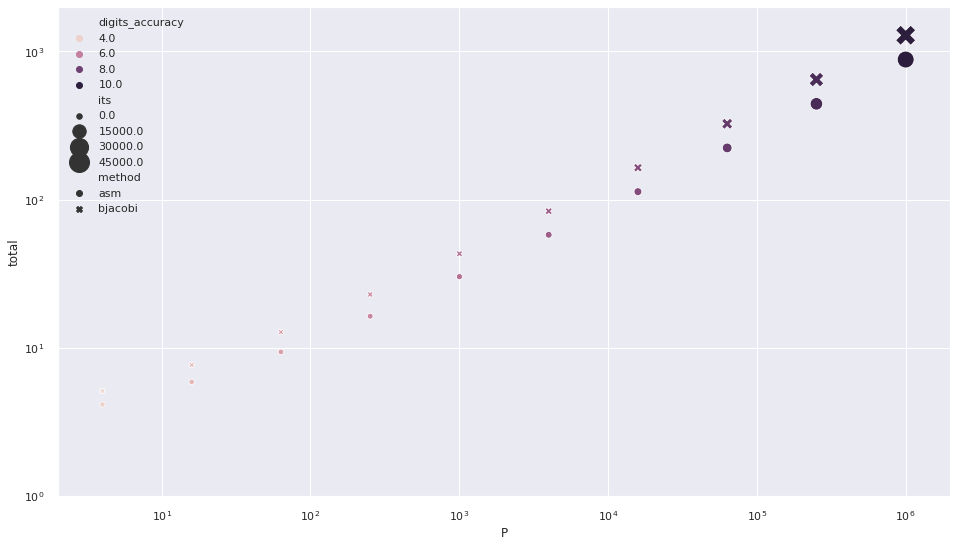

In [29]:
def make_stats(df):
    df['total'] = df.pc_setup + df.pc_apply + df.matmult + df.gmres
    df['cost'] = df.total * df.P
    df['efficiency'] = df.N / df.cost
    df['digits_accuracy'] = -np.log10(100*df.h**2)
    df['log10_time'] = np.log10(df.total)
    df['log10_cost'] = np.log10(df.cost)

mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
for h in [.002]:
    for scale in np.geomspace(2, 1e3, 10):
        for method, its in [('asm', asm_its), ('bjacobi', bjacobi_its)]:
            mdf = mdf.append(perf_model(h/scale, scale**2, method, its), ignore_index=True)
make_stats(mdf)

plt.rc('figure', figsize=(16,9))
grid = seaborn.scatterplot(x='P', y='total', style='method', hue='digits_accuracy', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(2, 2e6), yscale='log', ylim=(1, 2e3))
mdf

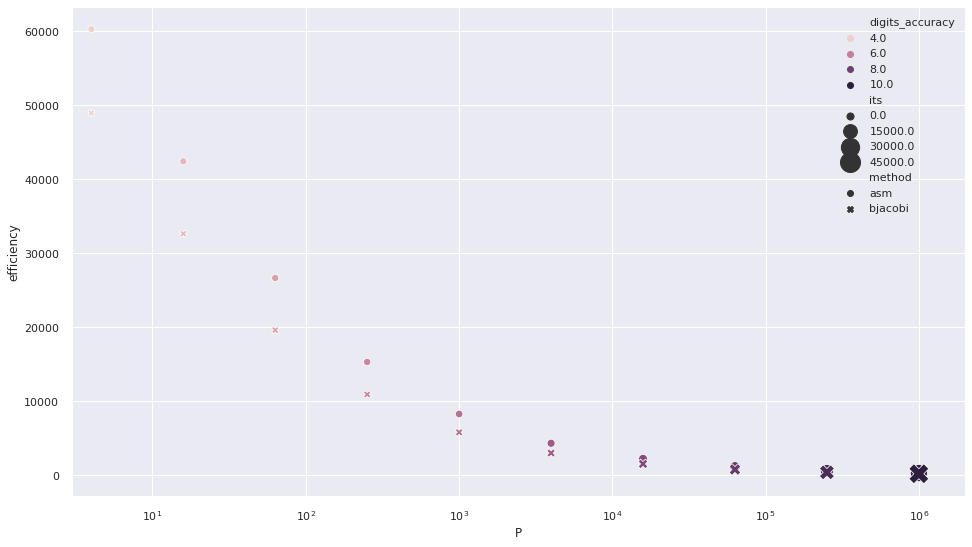

In [31]:
grid = seaborn.scatterplot(x='P', y='efficiency', style='method', hue='digits_accuracy', size='its', sizes=(50,400), data=mdf)
grid.axes.set(xscale='log', xlim=(3, 2e6));

### Strong scaling study: fixed global problem size

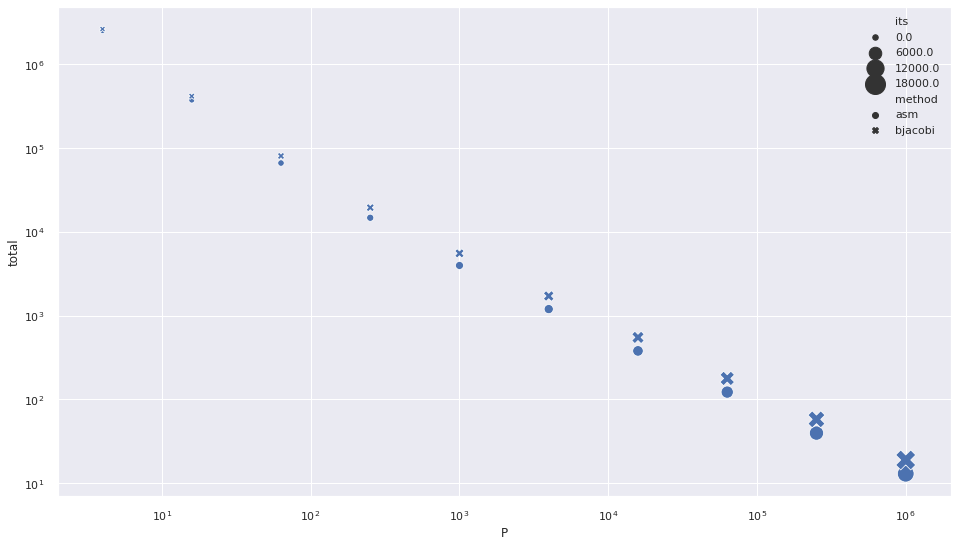

In [32]:
mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
for h in [1e-5]:
    for scale in np.geomspace(2, 1e3, 10):
        for method, its in [('asm', asm_its), ('bjacobi', bjacobi_its)]:
            mdf = mdf.append(perf_model(h, scale**2, method, its), ignore_index=True)
make_stats(mdf)

grid = seaborn.scatterplot(x='P', y='total', style='method', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(2, 2e6), yscale='log');

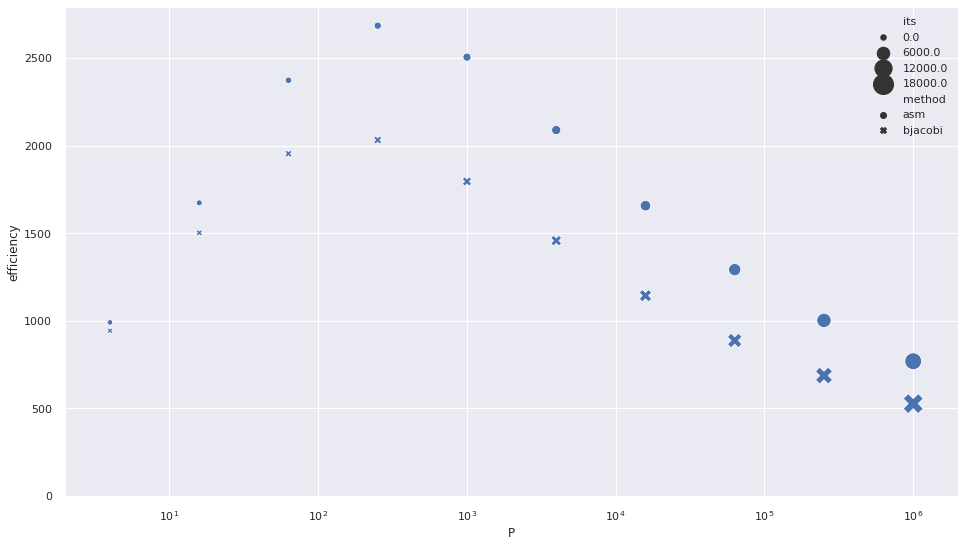

In [35]:
grid = seaborn.scatterplot(x='P', y='efficiency', style='method', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(2, 2e6), ylim=0);

## Accessible range

Now we grid sample the space of possible configurations to understand the shape of the [Pareto front](https://en.wikipedia.org/wiki/Pareto_efficiency) -- those configurations that are optimal in terms of the multiple objectives, which we take to be
* number of digits of accuracy
  * scales with $O(h^2)$ for this discretization
  * sometimes we could change the discretization to converge as $O(h^3)$ or a higher power; these are called "higher order methods"
* total execution time: how long we have wait for the parallel computation to complete
* cost: how many node hours are we charged for
* efficiency: given the required problem size to reach desired accuracy, how well are the node resources being used
  * we measure here as number of degrees of freedom solved per second per core
  
All of these metrics have tangible units and none are input parameters.  We'll map out the best configurations possible within a class of algorithms and, after identifying a Pareto optimal case that we would like to run, can check the input parameters to see how to run it on a real machine.

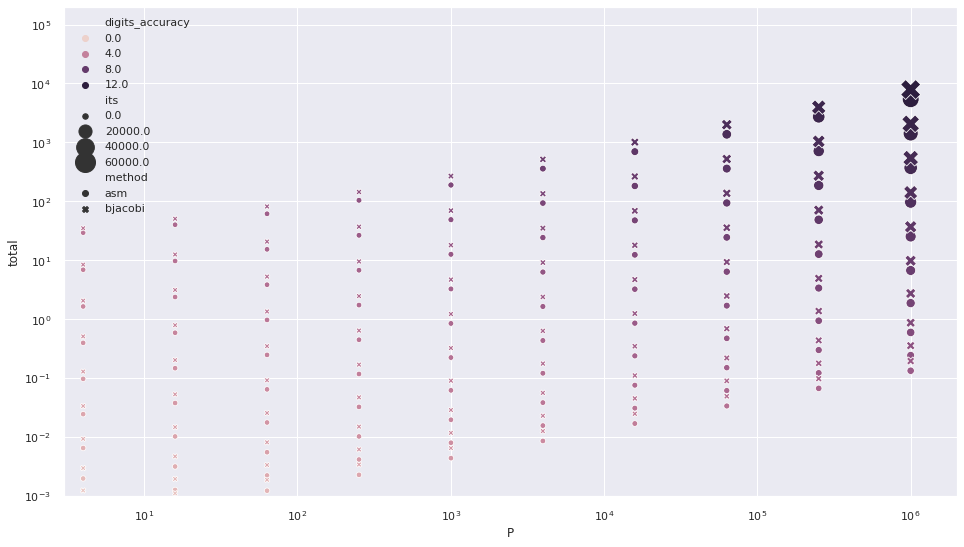

In [36]:
mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
for h in np.geomspace(1e-3, .1, 10):
    for scale in np.geomspace(2, 1e3, 10):
        for method, its in [('asm', asm_its), ('bjacobi', bjacobi_its)]:
            mdf = mdf.append(perf_model(h/scale, scale**2, method, its), ignore_index=True)
make_stats(mdf)

grid = seaborn.scatterplot(x='P', y='total', style='method', hue='digits_accuracy', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(3, 2e6), yscale='log', ylim=(1e-3, 2e5));

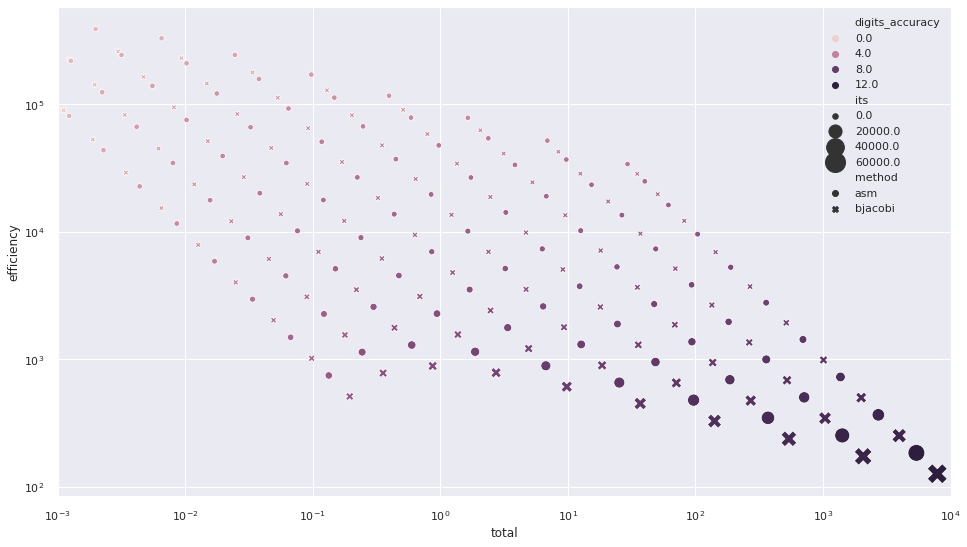

In [37]:
grid = seaborn.scatterplot(x='total', y='efficiency', style='method', hue='digits_accuracy', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(1e-3, 1e4), yscale='log');

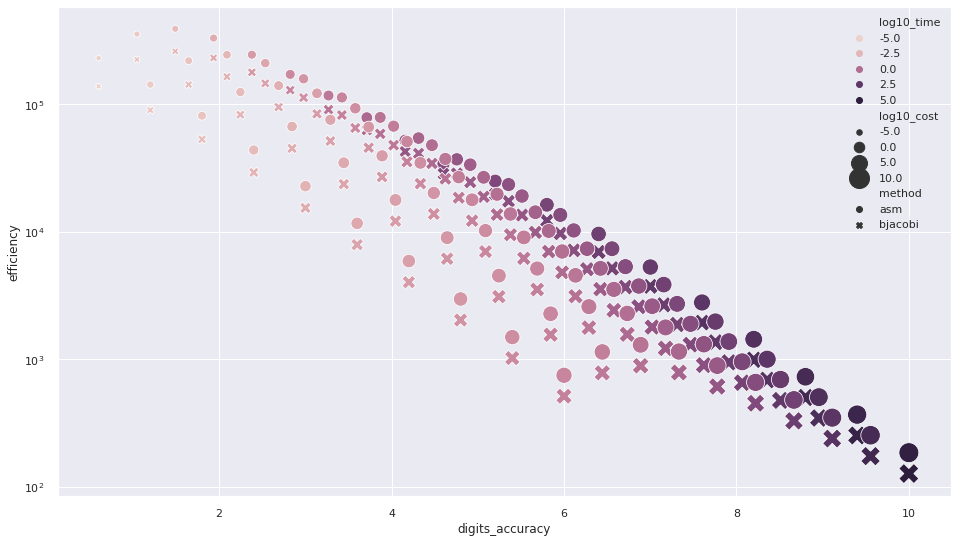

In [40]:
grid = seaborn.scatterplot(x='digits_accuracy', y='efficiency', style='method', hue='log10_time', size='log10_cost', sizes=(30,400), data=mdf)
grid.axes.set(yscale='log');

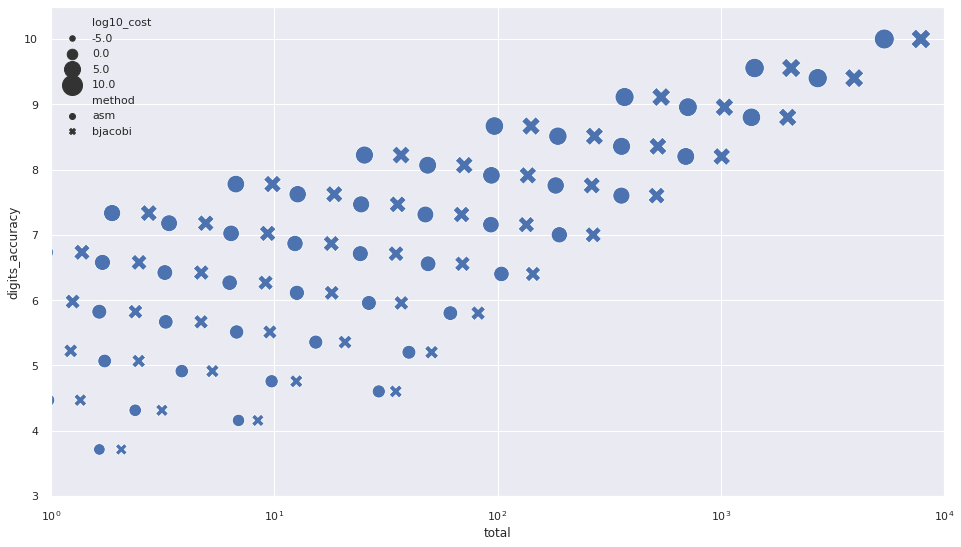

In [43]:
grid = seaborn.scatterplot(x='total', y='digits_accuracy', style='method', size='log10_cost', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(1, 1e4), ylim=3);

## Two-level methods

Two-level methods add a coarse space $P_0$ to the preconditioner

$$ M^{-1} = P_0 A_0^{-1} P_0^T + \sum_{i=1}^{\text{subdomains}} P_i A_i^{-1} P_i^T $$

or a similar combination.  In most formulations, the size of the coarse problem $A_0 = P_0^T A P_0$ is proportional to the number of subdomains.

Compare the figures below with those above to see how two-level methods open up new accessible ranges and bring their own tradeoffs.

In [50]:
def perf_model_2level(h, P, method, regress_its):
    n1 = 1/h
    N = n1**2
    n = N / P
    H = 1/np.sqrt(P)
    its = regress_its.intercept + regress_its.slope / np.sqrt(H*h) * H
    nref = (2**9 + 1)**2/2 # 8 levels of refinement from a 3x3 (2x2 element) grid
    pc_setup = 8.5827e-01 / nref**1.5 * n**1.5
    pc_setup += 8.5827e-01 / nref**1.5 * (4*P)**1.5
    pc_apply = 3.3956e-01 / 26 / (nref * np.log(nref)) * (n * np.log(n) + 4*P * np.log(4*P))
    matmult =  2.8539e-02 / 25 / nref * n
    gmres = 8.4230e-02 / 25 / nref * n + 30e-6
    total = pc_setup + its*(pc_apply + matmult + gmres)
    return dict(h=h, H=H, n=n, N=N, P=P, method=method, its=its,
                pc_setup=pc_setup, pc_apply=its*pc_apply, matmult=its*matmult,
                gmres=its*gmres)

### Strong scaling

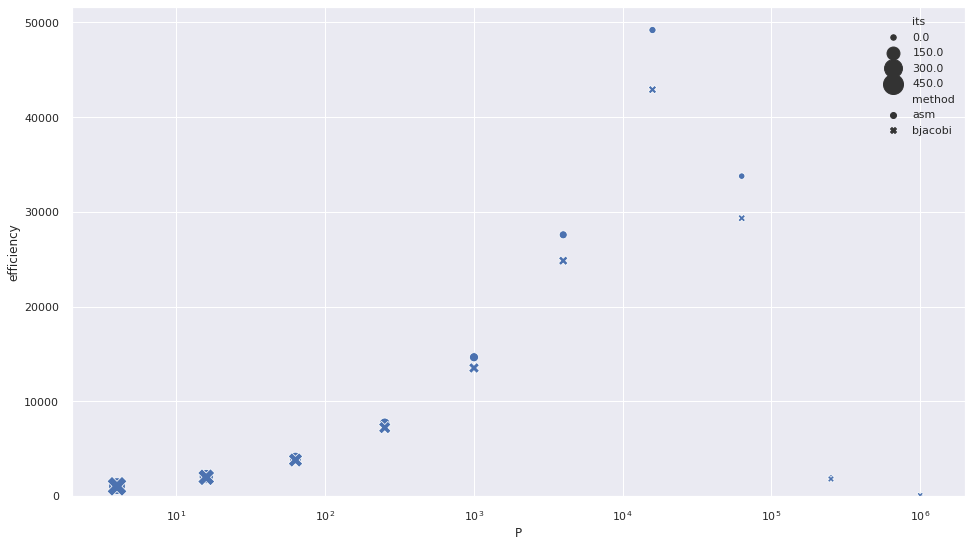

In [50]:
mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
for h in [1e-5]:
    for scale in np.geomspace(2, 1e3, 10):
        for method, its in [('asm', asm_its), ('bjacobi', bjacobi_its)]:
            mdf = mdf.append(perf_model_2lev(h, scale**2, method, its), ignore_index=True)
make_stats(mdf)
grid = seaborn.scatterplot(x='P', y='efficiency', style='method', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(2, 2e6), ylim=0);

* Why does efficiency drop off on the left?
* Why does it drop off on the right?

### Accessible range

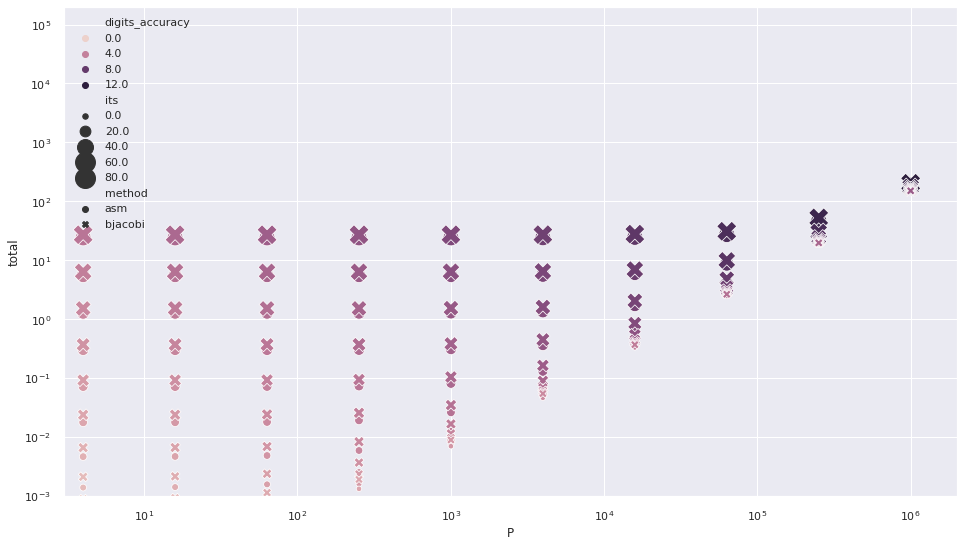

In [45]:
mdf = pandas.DataFrame(columns='h H n N P method its pc_setup pc_apply matmult gmres'.split())
for h in np.geomspace(1e-3, .1, 10):
    for scale in np.geomspace(2, 1e3, 10):
        for method, its in [('asm', asm_its), ('bjacobi', bjacobi_its)]:
            mdf = mdf.append(perf_model_2level(h/scale, scale**2, method, its), ignore_index=True)
make_stats(mdf)

grid = seaborn.scatterplot(x='P', y='total', style='method', hue='digits_accuracy', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(3, 2e6), yscale='log', ylim=(1e-3, 2e5));

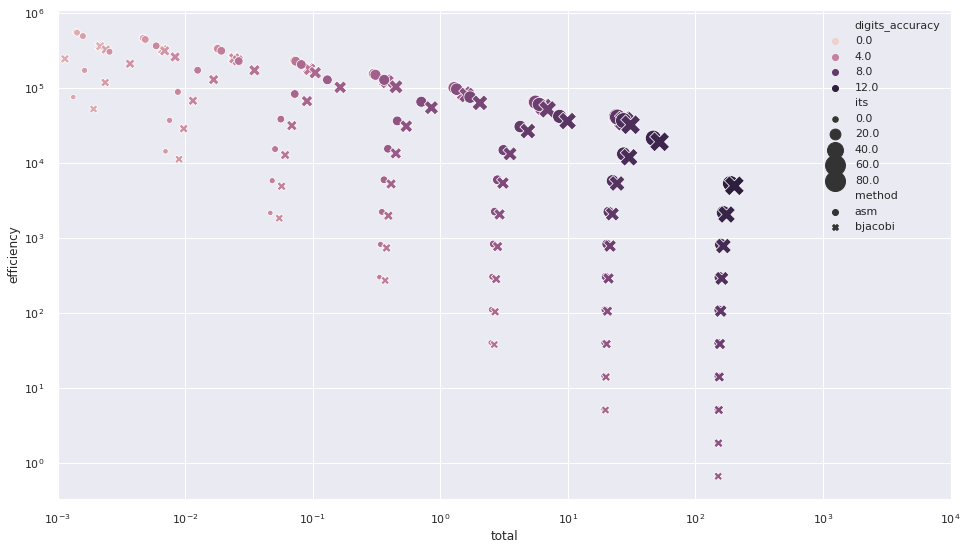

In [46]:
grid = seaborn.scatterplot(x='total', y='efficiency', style='method', hue='digits_accuracy', size='its', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(1e-3, 1e4), yscale='log');

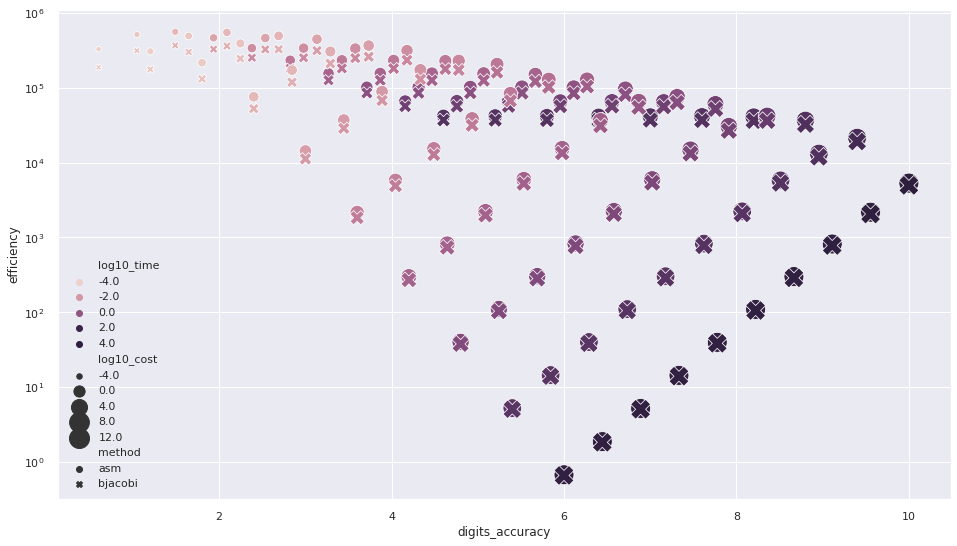

In [47]:
grid = seaborn.scatterplot(x='digits_accuracy', y='efficiency', style='method', hue='log10_time', size='log10_cost', sizes=(30,400), data=mdf)
grid.axes.set(yscale='log');

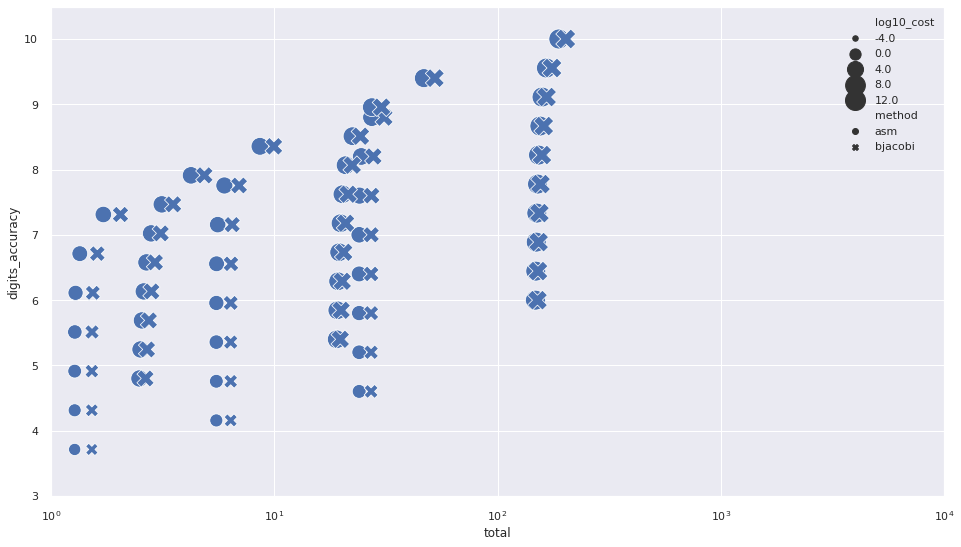

In [48]:
grid = seaborn.scatterplot(x='total', y='digits_accuracy', style='method', size='log10_cost', sizes=(30,400), data=mdf)
grid.axes.set(xscale='log', xlim=(1, 1e4), ylim=3);